In [19]:
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.vector_ar.var_model import VAR
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pandas.plotting import autocorrelation_plot

In [13]:
np.set_printoptions(suppress=True)

In [14]:
df = pd.read_csv('for_time_series_VAR_model.csv')

In [17]:
df_Pedestrian=df[['Total_Pedestrian_Count_per_day','Date']]

#Augmented Dickey Fuller test (ADF Test)
result = adfuller(df['Total_Pedestrian_Count_per_day'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

#Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)
result = kpss(df['Total_Pedestrian_Count_per_day'].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.1340124129475764
p-value: 0.23105973610232755
Critial Values:
   1%, -3.4334544462214303
Critial Values:
   5%, -2.8629114161159666
Critial Values:
   10%, -2.5675000767713883

KPSS Statistic: 0.865304
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


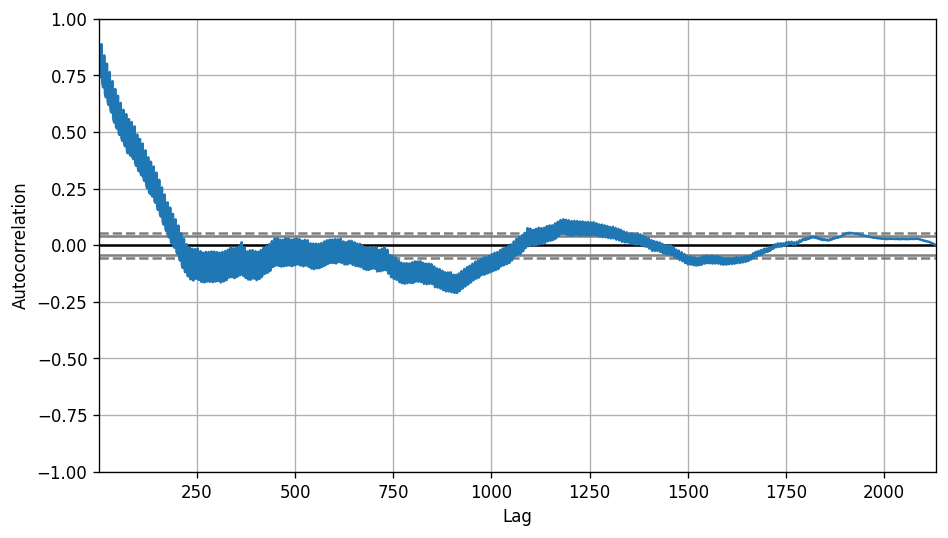

In [20]:
#Explore whether the serise has seasonality
# Draw Plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df['Total_Pedestrian_Count_per_day'].tolist())

In [3]:
df=df[['Covid Restrictions','Public_Holiday','Rainfall amount (millimetres)',
      'Minimum temperature (Degree C)','Maximum temperature (Degree C)',
      'Daily global solar exposure (MJ/m*m)','Total_Pedestrian_Count_per_day','Date']]

# convert categorical data to numeric
df = df.replace({
                    "Covid Restrictions": {'No restriction':0,'Restrictions':1},
                    "Public_Holiday": {'Public Holiday':1,'Not a public holiday':0},
                 })    
df['Date'] = pd.to_datetime(df['Date'])
data = df.drop(['Date'],axis=1)
data.index = df.Date

In [4]:
#checking stationarity
from statsmodels.tsa.vector_ar.vecm import coint_johansen
#since the test works for only 12 variables, I have randomly dropped
#in the next iteration, I would drop another and check the eigenvalues
#johan_test_temp = data.drop(['day_of_week','monthly_index','year','day_of_year'], axis=1)
coint_johansen(data,-1,1).eig


array([0.32995253, 0.27542072, 0.23487175, 0.21158113, 0.06266949,
       0.00277545, 0.00000201])

In [5]:
#creating the train and validation set
train = data[:int(0.8*(len(data)))]
valid = data[int(0.8*(len(data))):]

#fit the model
model = VAR(endog=train)
model_fit = model.fit()

# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(valid))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


In [6]:
#model_fit.summary()

In [8]:
#converting predictions to dataframe
cols = data.columns
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,6):
  for i in range(0, len(prediction)):
    pred.iloc[i][j] = prediction[i][j]

#check rmse
for i in cols:
  print('rmse value for', i, 'is : ', sqrt(mean_squared_error(pred[i], valid[i])))

TypeError: ignored

In [ ]:
pred

In [ ]:
#make final predictions
model = VAR(endog=data)
model_fit = model.fit()
y_final = model_fit.forecast(model_fit.y, steps=1)
print(y_final)